In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import learning_curve, validation_curve
from scipy.stats import randint,zscore,skew,kurtosis
from sklearn.metrics import r2_score

In [2]:
df_dish = pd.read_csv('dish.csv')
df_dish.shape

(382941, 37)

### Remove Outliers

In [3]:
# remove outliers
df_dish1 = df_dish[(df_dish['price'] > 0) & (df_dish['price'] < 100)]
df_dish1.shape

(380211, 37)

In [4]:
print('removed {} records'.format(df_dish.shape[0] - df_dish1.shape[0]))

removed 2730 records


In [5]:
print(np.mean(df_dish1['price']))
print(np.std(df_dish1['price']))

21.366793701392123
10.297593457517449


### Correlation Metrics

In [6]:
corrmat = df_dish1.corr()
corrmat['price'].sort_values(ascending=False).head(11)

price                    1.000000
net_price                0.613530
volume                   0.232513
staple_num               0.222103
has_staple               0.162947
tmr_only                 0.152634
is_recommend             0.133886
sequence                 0.089753
cooking_time             0.089705
sequence_in_catalogue    0.055576
source                   0.042887
Name: price, dtype: float64

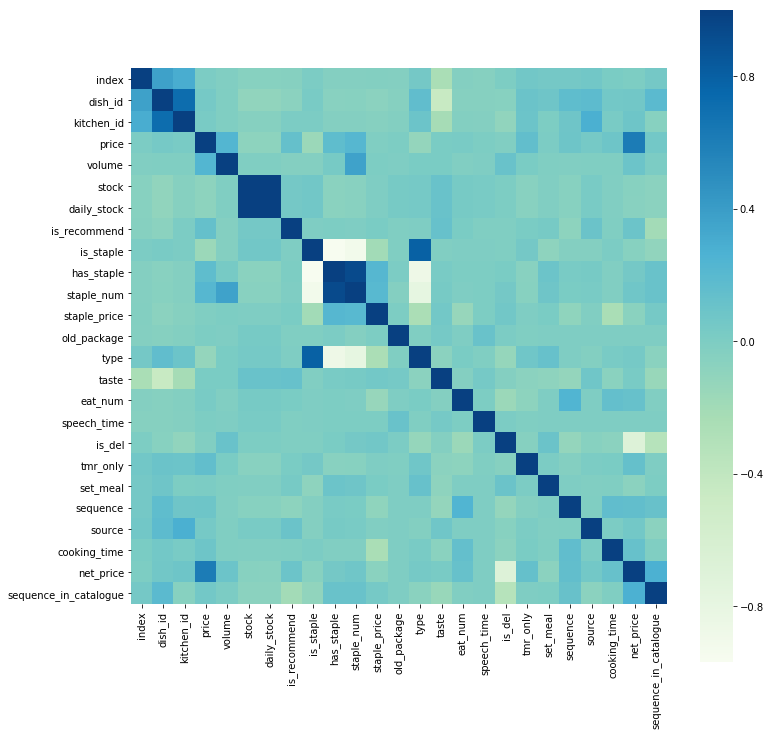

In [7]:
df_dish2 = df_dish1.drop(['tomorrow_stock','staple_type', 'is_new'], axis = 1)
corrmat1 = df_dish2.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat1, vmax=1, square=True, cmap="GnBu");
plt.show()

### Setup Models

In [5]:
def split_data(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42)

    X_train = train.drop(['price'], axis=1)
    y_train = train['price']

    X_test = test.drop(['price'], axis=1)
    y_test = test['price'] 
    return X_train, y_train, X_test, y_test

In [6]:
def evaluation(x,y,model):
    price_predictions = model.predict(x)
    mse = mean_squared_error(y, price_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, price_predictions)
    r2 = r2_score(y, price_predictions)
    return 'RMSE:{}'.format(rmse), 'MAE:{}'.format(mae),'R-square:{}'.format(r2)

In [7]:
def linreg(X_train,y_train, X_test, y_test):
    linreg = LinearRegression().fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, linreg)))
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, linreg)))

In [8]:
def linridge(X_train,y_train, X_test, y_test):
    linridge = Ridge(alpha=20.0).fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, linridge)))
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, linridge)))

In [9]:
def linlasso(X_train,y_train, X_test, y_test):
    linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, linlasso)))
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, linlasso)))

In [10]:
def polynomial(X_train,y_train, X_test, y_test):
    poly = PolynomialFeatures(degree=2)
    X_train_ploy = poly.fit_transform(X_train)
    X_test_ploy = poly.fit_transform(X_test)
    linreg = LinearRegression().fit(X_train_ploy, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train_ploy, y_train, linreg)))
    print('out-sample evaluation:{}'.format(evaluation(X_test_ploy, y_test, linreg)))

In [11]:
def tree_reg(X_train,y_train, X_test, y_test):
    tree_reg = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, tree_reg)))
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, tree_reg)))

In [12]:
def forest_reg(X_train,y_train, X_test, y_test):
    forest_reg = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, forest_reg)))
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, forest_reg)))

In [13]:
kitchen_prices = df_dish1.groupby('kitchen_id')['price'].agg(['median'])
kitchen_prices['kitchen_id'] = kitchen_prices.index
kitchen_prices = kitchen_prices.rename(columns={'median':'kitchen_price'})
df_dish3 = pd.merge(df_dish1, kitchen_prices, on='kitchen_id', how='left')
df_dish4 = df_dish3[['kitchen_price','price']]

In [14]:
df_dish5 = df_dish3[['volume','is_recommend','is_staple','has_staple','staple_num','type','taste','eat_num','tmr_only',
                     'set_meal','sequence','source','cooking_time','kitchen_price','price']]
df_dish5.fillna(0, inplace=True)

### Model 3 Dataframe

In [15]:
df_order = pd.read_csv('order.csv')
kitchen_orders = df_order.groupby('kitchen_id').size().reset_index(name='kitchen_orders')
kitchen_orders.head()

,kitchen_id,kitchen_orders
0,30,628
1,55,503
2,66,419
3,158,2
4,166,2


In [16]:
df_dish6 = pd.merge(df_dish3, kitchen_orders, on='kitchen_id', how='left')

In [17]:
df_dish6.head()

,index,dish_id,kitchen_id,name,price,volume,stock,tomorrow_stock,daily_stock,is_recommend,...,set_meal,sequence,source,materials,is_new,cooking_time,net_price,sequence_in_catalogue,kitchen_price,kitchen_orders
0,553,293558,19530,紫菜蛋花汤,1,0,10,99,10,0,...,0.0,1.0,1.0,NaN,0.0,0.0,1.0,4.0,19.0,NaN
1,895,293904,55290,干米饭,1,0,10,99,10,0,...,0.0,1.0,1.0,NaN,0.0,0.0,1.0,2.0,18.0,600.0
2,1713,294722,85614,馒头,1,0,50,99,50,0,...,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,20.0,NaN
3,1910,294919,38618,素炒黄豆芽,1,0,99,99,99,0,...,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,18.0,100.0
4,1982,294991,85211,美女小份米饭,1,0,5,99,5,0,...,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,19.0,565.0


In [142]:
df_dish6['kitchen_price'].value_counts().sort_index(ascending=True).head(80)

1.0        91
1.5         4
2.0       225
3.0       536
4.0        13
5.0        87
5.5        34
6.0        55
7.0        49
7.5        54
8.0       263
9.0        92
9.5        30
10.0      567
10.5       32
11.0      176
11.5      112
12.0     2059
12.5      254
13.0     1288
13.5      558
14.0     1553
14.5      326
15.0    15315
15.5     1854
16.0    18466
16.5     2256
17.0    10802
17.5     2472
18.0    74591
        ...  
28.5      244
29.0     1397
29.5      218
30.0     2247
30.5       26
31.0      357
31.5       70
32.0     1127
32.5       48
33.0      215
33.5      106
34.0      334
34.5       34
35.0      683
35.5       90
36.0      368
36.5      134
37.0       69
37.5       42
38.0      941
38.5       24
39.0      119
40.0      102
41.0        7
41.5        4
42.0       21
42.5       14
43.0       64
43.5        4
44.0       50
Name: kitchen_price, Length: 80, dtype: int64

In [153]:
df_dish6[df_dish6['kitchen_price'] == 30].kitchen_id.value_counts().head()

25967    140
20886    119
44959    112
11227    110
76776     72
Name: kitchen_id, dtype: int64

In [155]:
df_dish6[df_dish6['kitchen_id'] ==44959  ].kitchen_orders

2648      866.0
19796     866.0
22097     866.0
22619     866.0
22629     866.0
29905     866.0
29906     866.0
29913     866.0
102823    866.0
105416    866.0
105417    866.0
150866    866.0
160264    866.0
164114    866.0
170056    866.0
172049    866.0
214421    866.0
246361    866.0
248835    866.0
252426    866.0
259259    866.0
260002    866.0
260854    866.0
276509    866.0
279351    866.0
279353    866.0
284824    866.0
286549    866.0
286550    866.0
286553    866.0
          ...  
367706    866.0
367738    866.0
367768    866.0
368263    866.0
368323    866.0
368425    866.0
369755    866.0
370077    866.0
370141    866.0
370150    866.0
371702    866.0
371798    866.0
371997    866.0
372456    866.0
373040    866.0
373042    866.0
373320    866.0
374554    866.0
374569    866.0
374632    866.0
374985    866.0
375022    866.0
376379    866.0
378273    866.0
379030    866.0
379169    866.0
379170    866.0
379630    866.0
379932    866.0
380209    866.0
Name: kitchen_orders, Le

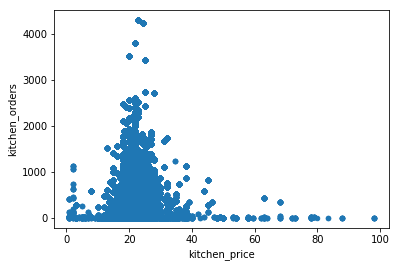

In [119]:
ax1 = df_dish6.plot.scatter(x='kitchen_price',
                    y='kitchen_orders')

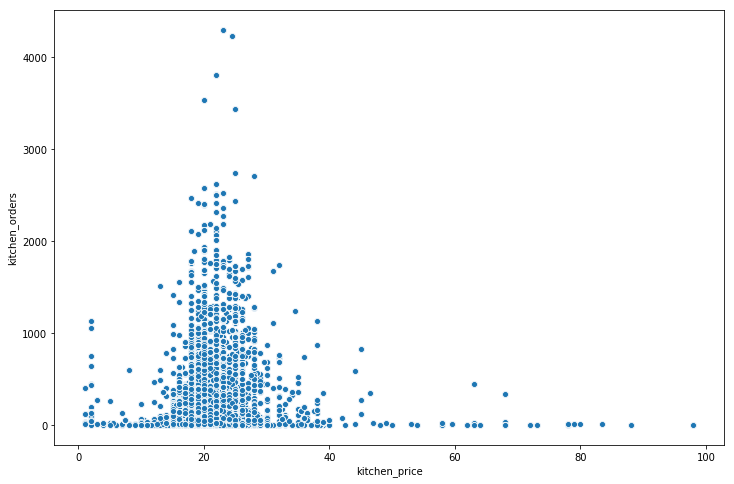

In [126]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='kitchen_price',
                    y='kitchen_orders', data=df_dish6)

In [17]:
df_dish6 = pd.merge(df_dish3, kitchen_orders, on='kitchen_id', how='left')
df_dish8 = df_dish6.drop(columns =['index','dish_id','kitchen_id','name','tags','description','check_time','refusal_ground','create_time',\
                                   'update_time','speech_time','dish_feature','materials','net_price','kitchen_price'], axis=1).fillna(0)

In [18]:
X_train, y_train, X_test, y_test = split_data(df_dish8)

In [19]:
linreg(X_train, y_train, X_test, y_test)

in-sample evaluation:('RMSE:9.474140838925305', 'MAE:6.234413201379173', 'R-square:0.15306675976685724')
out-sample evaluation:('RMSE:9.491262417040403', 'MAE:6.23919653617225', 'R-square:0.15235515737479344')


In [20]:
linridge(X_train, y_train, X_test, y_test)

in-sample evaluation:('RMSE:9.474219779419354', 'MAE:6.2347281479981085', 'R-square:0.1530526460634446')
out-sample evaluation:('RMSE:9.492037436343571', 'MAE:6.2398996009613885', 'R-square:0.1522167210092148')


In [21]:
linlasso(X_train,y_train, X_test, y_test)

in-sample evaluation:('RMSE:10.189517605744381', 'MAE:6.661476944387024', 'R-square:0.02033689289642837')
out-sample evaluation:('RMSE:10.19537903399046', 'MAE:6.668931667351712', 'R-square:0.021923747974204266')


In [22]:
polynomial(X_train,y_train, X_test, y_test)

in-sample evaluation:('RMSE:9.33695348946341', 'MAE:6.144169185879009', 'R-square:0.17741668499004126')
out-sample evaluation:('RMSE:9.380209017445667', 'MAE:6.158552096606272', 'R-square:0.17207500631006445')


In [23]:
tree_reg(X_train,y_train, X_test, y_test)

in-sample evaluation:('RMSE:5.380143469698648', 'MAE:2.131115352849476', 'R-square:0.7268776634331169')
out-sample evaluation:('RMSE:11.65772531082138', 'MAE:7.59930050538662', 'R-square:-0.27877341110523113')


In [24]:
forest_reg(X_train,y_train, X_test, y_test)

in-sample evaluation:('RMSE:9.110755975717021', 'MAE:6.032359527625553', 'R-square:0.2167898006521558')
out-sample evaluation:('RMSE:9.312928096687573', 'MAE:6.110120385422923', 'R-square:0.1839092383279307')


In [25]:
list(df_dish8)

['price',
 'volume',
 'stock',
 'tomorrow_stock',
 'daily_stock',
 'is_recommend',
 'is_staple',
 'has_staple',
 'staple_type',
 'staple_num',
 'staple_price',
 'old_package',
 'type',
 'taste',
 'eat_num',
 'is_del',
 'tmr_only',
 'set_meal',
 'sequence',
 'source',
 'is_new',
 'cooking_time',
 'sequence_in_catalogue',
 'kitchen_orders']

### Hyper-parameters Tuning 

In [26]:
forest_reg = RandomForestRegressor()
param_grid = [{'n_estimators': [5, 10, 50, 100], 'max_features':[3, 6, 9, 12]},{'n_estimators': [5, 10, 50, 100],'max_features': [3, 6, 9, 12]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring="neg_mean_squared_error")

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [5, 10, 50, 100], 'max_features': [3, 6, 9, 12]}, {'n_estimators': [5, 10, 50, 100], 'max_features': [3, 6, 9, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
cvres=grid_search.cv_results_
#for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
#    print(np.sqrt(-mean_score), params)
print(grid_search.best_params_)

{'max_features': 12, 'n_estimators': 100}


In [19]:
forest_reg_2 = RandomForestRegressor(random_state=42,max_features=12, n_estimators=100,max_depth=10)
forest_reg_2.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_2)

('RMSE:9.104350988743485',
 'MAE:6.030108576059149',
 'R-square:0.21789062868895148')

In [20]:
evaluation(X_test, y_test, forest_reg_2)

('RMSE:9.291700737608444',
 'MAE:6.101316292482479',
 'R-square:0.1876253002182211')

In [30]:
param_distribs = {'n_estimators': randint(low=1, high=100),'max_features': randint(low=1, high=20),}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2eb0a5f8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2eb0a978>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [31]:
cvres = rnd_search.cv_results_
#for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
#    print(np.sqrt(-mean_score), params)
print(rnd_search.best_params_)

{'max_features': 11, 'n_estimators': 75}


In [28]:
forest_reg_3 = RandomForestRegressor(random_state=42,max_features=11, n_estimators= 75 ,max_depth=10)
forest_reg_3.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_3)

('RMSE:9.106706511846877',
 'MAE:6.029899172472375',
 'R-square:0.2174858738596861')

In [29]:
evaluation(X_test, y_test, forest_reg_3)

('RMSE:9.290641286509423',
 'MAE:6.099712530473142',
 'R-square:0.18781054557327692')

### Feature Selection

In [34]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = ['volume',
 'stock',
 'tomorrow_stock',
 'daily_stock',
 'is_recommend',
 'is_staple',
 'has_staple',
 'staple_type',
 'staple_num',
 'staple_price',
 'old_package',
 'type',
 'taste',
 'eat_num',
 'is_del',
 'tmr_only',
 'set_meal',
 'sequence',
 'source',
 'is_new',
 'cooking_time',
 'sequence_in_catalogue',
 'kitchen_price',
 'kitchen_orders']
feature_importance = pd.DataFrame(feature_importances, features)
feature_importance.reset_index(level=0, inplace=True)
feature_importance = feature_importance.sort_values(0, ascending=False).rename(index=str, columns={"index": "Feature", 0: "importance"})
feature_importance.head(15)

,Feature,importance
22,kitchen_price,0.381931
23,kitchen_orders,0.096293
21,sequence_in_catalogue,0.094670
13,eat_num,0.083753
3,daily_stock,0.047042
1,stock,0.045419
17,sequence,0.043532
0,volume,0.034406
8,staple_num,0.028857
12,taste,0.027490


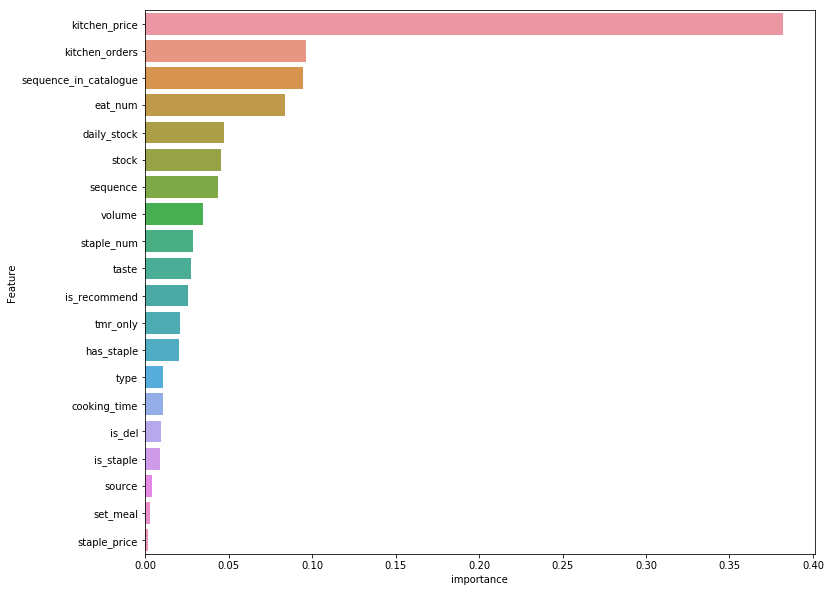

In [35]:
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
ax = sns.barplot( y='Feature', x= 'importance', data=feature_importance.head(20))

In [36]:
import_features = feature_importance[feature_importance['importance']> 0.01].Feature.values
import_features

array(['kitchen_price', 'kitchen_orders', 'sequence_in_catalogue',
       'eat_num', 'daily_stock', 'stock', 'sequence', 'volume',
       'staple_num', 'taste', 'is_recommend', 'tmr_only', 'has_staple',
       'type', 'cooking_time'], dtype=object)

In [37]:
df_dish9 = pd.DataFrame(data=df_dish8,columns=['kitchen_price', 'kitchen_orders', 'sequence_in_catalogue',
       'eat_num', 'daily_stock', 'stock', 'sequence', 'volume', 'taste',
       'is_recommend', 'staple_num', 'has_staple', 'tmr_only', 'type',
       'cooking_time','price'])
X_train, y_train, X_test, y_test = split_data(df_dish9)

In [38]:
forest_reg_2.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_2)

('RMSE:7.985467781399654',
 'MAE:5.395294559440073',
 'R-square:0.3983135533109725')

In [39]:
evaluation(X_test, y_test, forest_reg_2)

('RMSE:8.165167820365214',
 'MAE:5.458184542414011',
 'R-square:0.37266980395840976')

### Featue Selection:  Chisqure

In [31]:
# referred to Github:rohandhupar/online-news-popularity-prediction
from scipy.stats import chi2_contingency

global yes
global no
yes=[]
no=[]
class chisquare:
    def __init__(self,dataframe):
        self.df=dataframe
        self.p=None
        self.chi2=None
        self.dof=None
        self.expected=None
        self.observed=None
        
    def print_result(self,colx,alpha):
        result=""
        if self.p<alpha:
            result="{0} is important factor for pridiction".format(colx)
            yes.append(colx)
        else :
            result="{0} is not  important factor for pridiction".format(colx)
            no.append(colx)
        print(result)
    def testofindependence(self,colx,coly,alpha=0.05):
        x=self.df[colx].astype(str)
        y=self.df[coly].astype(str)
        self.observed=pd.crosstab(x,y)
        chi2,p,dof,expected=chi2_contingency(self.observed.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        self.expected = pd.DataFrame(expected, columns=self.observed.columns, index = self.observed.index)
        
        self.print_result(colx,alpha)
        
        
cT = chisquare(df_dish8)

testColumns = ['volume',
 'stock',
 'tomorrow_stock',
 'daily_stock',
 'is_recommend',
 'is_staple',
 'has_staple',
 'staple_type',
 'staple_num',
 'staple_price',
 'old_package',
 'type',
 'taste',
 'eat_num',
 'is_del',
 'tmr_only',
 'set_meal',
 'sequence',
 'source',
 'is_new',
 'cooking_time',
 'sequence_in_catalogue',
 'kitchen_orders']
for var in testColumns:
    cT.testofindependence(colx=var,coly='price' )

volume is important factor for pridiction
stock is important factor for pridiction
tomorrow_stock is not  important factor for pridiction
daily_stock is important factor for pridiction
is_recommend is important factor for pridiction
is_staple is important factor for pridiction
has_staple is important factor for pridiction
staple_type is not  important factor for pridiction
staple_num is important factor for pridiction
staple_price is important factor for pridiction
old_package is important factor for pridiction
type is important factor for pridiction
taste is important factor for pridiction
eat_num is important factor for pridiction
is_del is important factor for pridiction
tmr_only is important factor for pridiction
set_meal is important factor for pridiction
sequence is important factor for pridiction
source is important factor for pridiction
is_new is not  important factor for pridiction
cooking_time is important factor for pridiction
sequence_in_catalogue is important factor for pr

In [32]:
predf=pd.DataFrame(yes,columns=['yes'])
predf['yes'].values

array(['volume', 'stock', 'daily_stock', 'is_recommend', 'is_staple',
       'has_staple', 'staple_num', 'staple_price', 'old_package', 'type',
       'taste', 'eat_num', 'is_del', 'tmr_only', 'set_meal', 'sequence',
       'source', 'cooking_time', 'sequence_in_catalogue',
       'kitchen_orders'], dtype=object)

In [33]:
df_dish10 = pd.DataFrame(data=df_dish8,columns=['volume', 'stock', 'daily_stock', 'is_recommend', 'is_staple',
       'has_staple', 'staple_num', 'staple_price', 'old_package', 'type',
       'taste', 'eat_num', 'is_del', 'tmr_only', 'set_meal', 'sequence',
       'source', 'cooking_time', 'sequence_in_catalogue',
       'kitchen_orders','price'])

In [34]:
X_train, y_train, X_test, y_test = split_data(df_dish10)
forest_reg_2.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_2)

('RMSE:9.096175487807384',
 'MAE:6.026627048671724',
 'R-square:0.21929463101939717')

In [35]:
evaluation(X_test, y_test, forest_reg_2)

('RMSE:9.290800765462365',
 'MAE:6.100410291607307',
 'R-square:0.1877826619791333')

### RFE (Recursive Feature Elimination)

In [39]:
from sklearn.feature_selection import RFE

# get top 20 features for random forest model 3
rfe = RFE(forest_reg_2, 20)
fit = rfe.fit(X_train, y_train)
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

20
[ True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True]
[1 1 4 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1]


In [40]:
RFE_features = pd.DataFrame({'features':list(X_train), 'important':list(fit.support_)})
RFE_features[RFE_features['important'] == True].features.values

array(['volume', 'stock', 'daily_stock', 'is_recommend', 'is_staple',
       'has_staple', 'staple_num', 'staple_price', 'old_package', 'type',
       'taste', 'eat_num', 'is_del', 'tmr_only', 'set_meal', 'sequence',
       'source', 'cooking_time', 'sequence_in_catalogue',
       'kitchen_orders'], dtype=object)

In [42]:
df_dish11 = pd.DataFrame(data=df_dish8,columns=['volume', 'stock', 'daily_stock', 'is_recommend', 'is_staple',
       'has_staple', 'staple_num', 'staple_price', 'old_package', 'type',
       'taste', 'eat_num', 'is_del', 'tmr_only', 'set_meal', 'sequence',
       'source', 'cooking_time', 'sequence_in_catalogue',
       'kitchen_orders','price'])
X_train, y_train, X_test, y_test = split_data(df_dish11)
forest_reg_2.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_2)

('RMSE:9.096175487807384',
 'MAE:6.026627048671724',
 'R-square:0.21929463101939717')

In [43]:
evaluation(X_test, y_test, forest_reg_2)

('RMSE:9.290800765462365',
 'MAE:6.100410291607307',
 'R-square:0.1877826619791333')

### PCA(Principal Component Analysis)

In [21]:
X_train, y_train, X_test, y_test = split_data(df_dish8)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=17)
fit = pca.fit(X_train)
print(fit.explained_variance_ratio_)
reduced_features = pca.transform(X_train)
reduced_features = pd.DataFrame(reduced_features)

[9.45002534e-01 5.07625383e-02 2.01074060e-03 1.13912774e-03
 9.11485846e-04 1.54992845e-04 1.01355905e-05 2.69533892e-06
 2.02280715e-06 9.56459738e-07 8.47265615e-07 7.07472274e-07
 5.20819694e-07 2.89580850e-07 1.81064658e-07 1.28055231e-07
 6.45408735e-08]


In [23]:
X_train = reduced_features
forest_reg_2.fit(X_train, y_train)
evaluation(X_train, y_train, forest_reg_2)

('RMSE:9.026749938201245',
 'MAE:6.007056088815333',
 'R-square:0.23116644642595197')

In [24]:
fit = pca.fit(X_test)
print(fit.explained_variance_ratio_)
reduced_features_test = pca.transform(X_test)
reduced_features_test = pd.DataFrame(reduced_features_test)

[9.38253526e-01 5.76702794e-02 1.95429963e-03 1.05179033e-03
 8.83934009e-04 1.68925261e-04 9.76233379e-06 1.95177557e-06
 1.92313628e-06 9.26443092e-07 8.12872887e-07 6.80005751e-07
 5.08848367e-07 2.81777064e-07 1.82872901e-07 1.22906065e-07
 6.12644232e-08]


In [25]:
X_test = reduced_features_test
forest_reg_2.fit(X_test, y_test)
evaluation(X_test, y_test, forest_reg_2)

('RMSE:8.80354058768713',
 'MAE:5.901518737961149',
 'R-square:0.2707428371266908')

In [ ]:
model = forest_reg_2.fit(X_train, y_train)
price_predictions = model.predict(X_train)